In [3]:
import sys
sys.path.append('../src/')

import os
from typing import Dict
from os import PathLike
from pathlib import Path

import data_io

from harp.reader import create_reader

from utils import breathing_signal as lib
from utils import analysis_utils as analysis
from utils import processing
from utils import plotting_utils as plotting

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages
from tkinter import font
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter, MaxNLocator, FixedLocator
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
from scipy.optimize import curve_fit
import math 

from numpy.typing import ArrayLike
from typing import Literal, Tuple

sns.set_context('talk')

import warnings
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import ipywidgets as widgets
from IPython.display import display
from matplotlib.patches import Rectangle

pdf_path = r'Z:\scratch\vr-foraging\sessions'
base_path = 'Z:/scratch/vr-foraging/data/'

color1='#d95f02'
color2='#1b9e77'
color3='#7570b3'

color_dict = {0: color1, 1: color2, 2: color3}

# Define exponential function
def exponential_func(x, a, b):
    return a * np.exp(b * x)

def format_func(value, tick_number):
    return f"{value:.0f}"

# Batch 3 - Preward depletion with three odors. 

## Are the statistics that we impose the ones that the animals experience?

In [4]:
date = datetime.date.today()
date_string = "4/23/2024"
date = datetime.datetime.strptime(date_string, "%m/%d/%Y").date()

In [5]:
mouse = '716458'

In [19]:
session_found = False

directory = os.path.join(base_path, mouse)
files = os.listdir(os.path.join(base_path, mouse))

sorted_files = sorted(files, key=lambda x: os.path.getctime(os.path.join(directory, x)), reverse=True)

for file_name in sorted_files:
    
    print(file_name)
    session_path = os.path.join(base_path, mouse, file_name)
    session = file_name[:8]
    session_path = Path(session_path)
    
    if session_found == True:
        break
    
    if datetime.date.fromtimestamp(os.path.getctime(session_path)) != date:
        continue
    else:
        print('correct date found')
        session_found = True
    

    data = analysis.load_session_data(session_path)
    

    data['harp_olfactometer'].streams.OdorValveState.load_from_file()
    data['harp_olfactometer'].streams.EndValveState.load_from_file()
    data['software_events'].streams.ActiveSite.load_from_file()
    data['software_events'].streams.ChoiceFeedback.load_from_file()
    
    data['harp_behavior'].streams.OutputSet.load_from_file()
    data['harp_behavior'].streams.OutputClear.load_from_file()
    
    reward_sites, active_site, encoder_data, config = analysis.parse_data(data)
    
    previous_patch = 0
    total_success = 0

    for index, row in reward_sites.iterrows():
        if row['active_patch'] != previous_patch:
            previous_patch = row['active_patch']
            total_success = 0
        if row['reward_delivered'] != 0:
            total_success+=1
            
        reward_sites.loc[index, 'success_number'] = total_success

20240426T084054
20240425T082602
20240424T084924
20240423T082236
correct date found
20240422T091200


In [12]:
reward_sites = reward_sites.loc[reward_sites.has_choice == True]

summary = reward_sites.groupby(['visit_number','odor_label']).agg({'collected':'sum','visit_number':'count'})
summary['percent_collected'] = summary['collected'] / summary['visit_number']
summary.rename(columns={'visit_number':'visit_number_count'}, inplace=True)
summary.reset_index(inplace=True)

In [13]:
dict = {}
for i in range(len(data['config'].streams.tasklogic_input.data['environment_statistics']['patches'])):
    odor_label = data['config'].streams.tasklogic_input.data['environment_statistics']['patches'][i]['label']
    rate = data['config'].streams.tasklogic_input.data['environment_statistics']['patches'][i][ 'reward_specification']['reward_function']['probability']['c']
    offset = data['config'].streams.tasklogic_input.data['environment_statistics']['patches'][i][ 'reward_specification']['reward_function']['probability']['a']
    
    dict[odor_label] = {'rate':rate, 'offset':offset, 'color': color_dict[i]}

### Theoretical values extracted from an example session

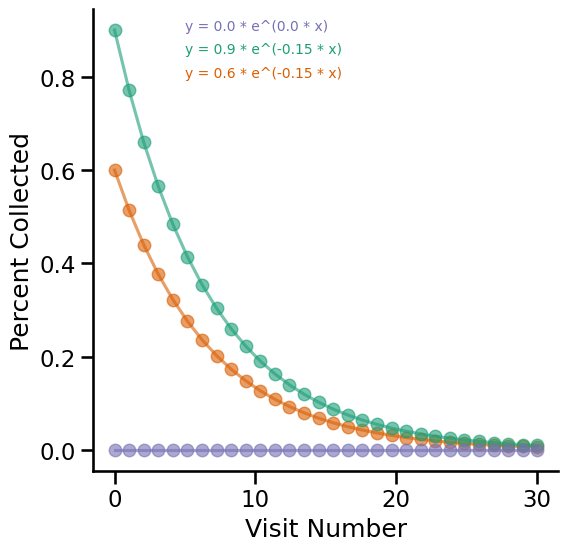

In [14]:
fig, ax = plt.subplots(1,1,figsize=(6, 6))
max_visit = 30
height = 0.8
x_values = np.linspace(0, max_visit, max_visit)

for odor in dict.keys():
    # Plot curve for this odor in theroy
    rate = dict[odor]['rate']
    offset = dict[odor]['offset']
    # Calculate y values using the power function y = ax^b
    y_values = offset * np.power(math.e, x_values* rate)
    ax.plot(x_values, y_values, color=dict[odor]['color'], alpha=0.6, label='Exponential Fit', marker='o')

    ax.text(5, height, f'y = {offset} * e^({rate} * x)', color=dict[odor]['color'], fontsize=10, )
    height +=0.05

plt.xlabel('Visit Number')
plt.ylabel('Percent Collected')
sns.despine()

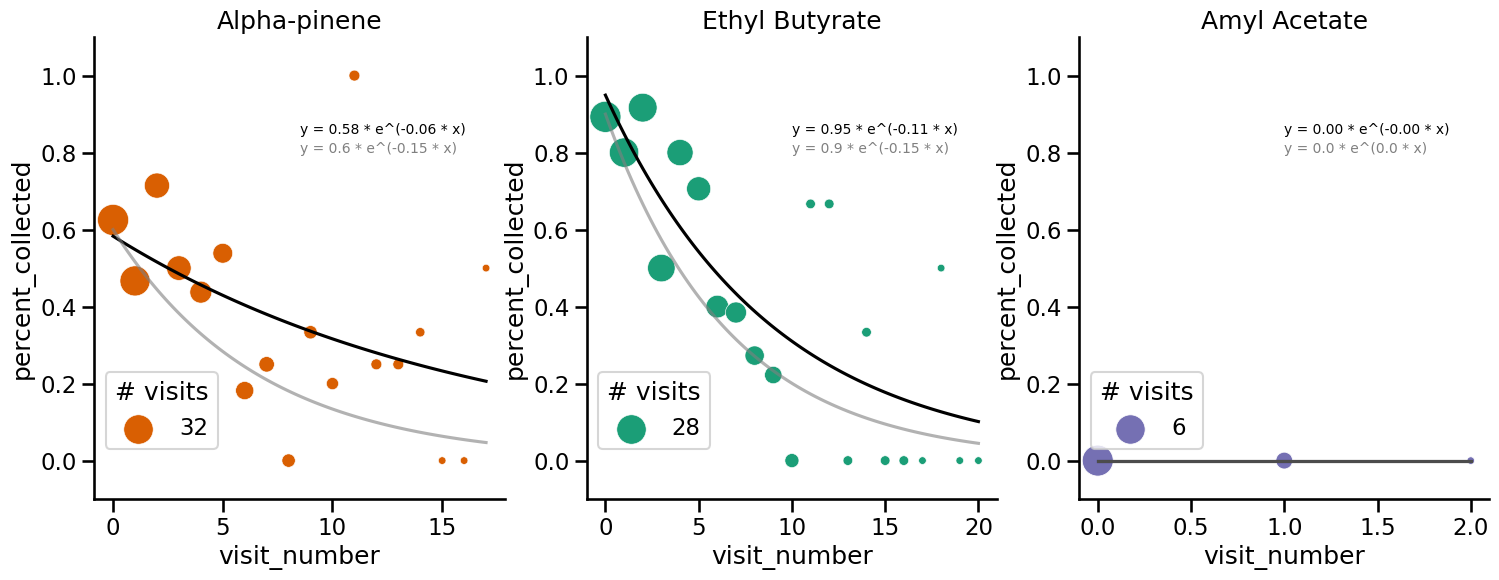

In [15]:
fig, ax = plt.subplots(1,3,figsize=(18, 6))
i = 0
for odor in dict.keys():

    odor_df = summary.loc[summary['odor_label'] == odor]
    # odor_df = odor_df.loc[~((odor_df.percent_collected == 1.0)&(odor_df.visit_number > 10))]
    odor_df = odor_df.loc[(odor_df.visit_number_count != 1.0)]

    sns.scatterplot(odor_df, x='visit_number', size="visit_number_count", sizes=(30, 500), y='percent_collected', color=dict[odor]['color'], ax=ax[i])
    
    # Plot exponential curve
    popt, pcov = curve_fit(exponential_func, odor_df['visit_number'], odor_df['percent_collected'],maxfev = 600, bounds=([-np.inf, -np.inf], [np.inf, 1]))
    
    # Plot curve for this odor in theroy
    rate = dict[odor]['rate']
    offset = dict[odor]['offset']
    if popt[1] < 0:
        x_values = np.linspace(odor_df['visit_number'].min(), odor_df['visit_number'].max(), 100)
        ax[i].plot(x_values, exponential_func(x_values, *popt), color='black', label='Exponential Fit')
        ax[i].plot(x_values, exponential_func(x_values, offset, rate), color='grey', alpha=0.6, label='Exponential Fit')
        ax[i].text(max(odor_df.visit_number)/2, 0.85, f'y = {popt[0]:.2f} * e^({popt[1]:.2f} * x)', color='black', fontsize=10, )
        ax[i].text(max(odor_df.visit_number)/2, 0.80, f'y = {offset} * e^({rate} * x)', color='grey', fontsize=10, )

    ax[i].legend(bbox_to_anchor=(0.0,0.3), loc='upper left', labels=[max(odor_df.visit_number_count)], markerscale=1.3, title='# visits')
    ax[i].set_ylim(-0.1,1.1)
    ax[i].set_title(odor)
    sns.despine()
    i += 1

In [28]:
summary = reward_sites.groupby(['success_number','odor_label']).agg({'collected':'sum','reward_delivered':'count','visit_number':'count'})
summary['percent_collected'] = summary['collected'] / summary['reward_delivered']
summary.rename(columns={'visit_number':'visit_number_count'}, inplace=True)
summary.reset_index(inplace=True)

In [29]:
summary

,success_number,odor_label,collected,reward_delivered,visit_number_count,percent_collected
0,0.0,Alpha-pinene,0.0,33,33,0.000000
1,0.0,Amyl Acetate,0.0,23,23,0.000000
2,0.0,Ethyl Butyrate,0.0,13,13,0.000000
3,1.0,Alpha-pinene,29.0,48,48,0.604167
4,1.0,Ethyl Butyrate,28.0,38,38,0.736842
5,2.0,Alpha-pinene,21.0,43,43,0.488372
6,2.0,Ethyl Butyrate,24.0,30,30,0.800000
7,3.0,Alpha-pinene,16.0,43,43,0.372093
8,3.0,Ethyl Butyrate,22.0,40,40,0.550000
9,4.0,Alpha-pinene,9.0,21,21,0.428571


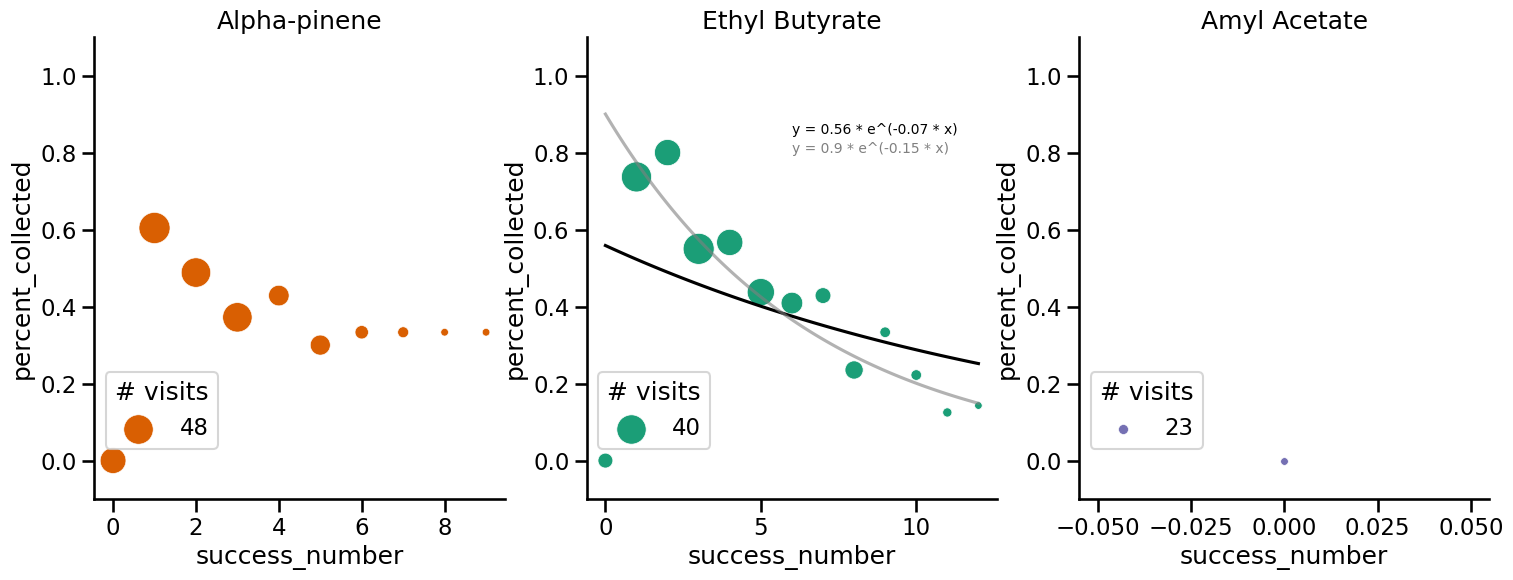

In [31]:
fig, ax = plt.subplots(1,3,figsize=(18, 6))
i = 0
for odor in dict.keys():

    odor_df = summary.loc[summary['odor_label'] == odor]
    # odor_df = odor_df.loc[~((odor_df.percent_collected == 1.0)&(odor_df.visit_number > 10))]
    odor_df = odor_df.loc[(odor_df.visit_number_count != 1.0)]

    sns.scatterplot(odor_df, x='success_number', size="visit_number_count", sizes=(30, 500), y='percent_collected', color=dict[odor]['color'], ax=ax[i])
    
    # Plot exponential curve
    popt, pcov = curve_fit(exponential_func, odor_df['success_number'], odor_df['percent_collected'],maxfev = 600, bounds=([-np.inf, -np.inf], [np.inf, 1]))
    
    # Plot curve for this odor in theroy
    rate = dict[odor]['rate']
    offset = dict[odor]['offset']
    if popt[1] < 0:
        x_values = np.linspace(odor_df['success_number'].min(), odor_df['success_number'].max(), 100)
        ax[i].plot(x_values, exponential_func(x_values, *popt), color='black', label='Exponential Fit')
        ax[i].plot(x_values, exponential_func(x_values, offset, rate), color='grey', alpha=0.6, label='Exponential Fit')
        ax[i].text(max(odor_df.success_number)/2, 0.85, f'y = {popt[0]:.2f} * e^({popt[1]:.2f} * x)', color='black', fontsize=10, )
        ax[i].text(max(odor_df.success_number)/2, 0.80, f'y = {offset} * e^({rate} * x)', color='grey', fontsize=10, )

    ax[i].legend(bbox_to_anchor=(0.0,0.3), loc='upper left', labels=[max(odor_df.visit_number_count)], markerscale=1.3, title='# visits')
    ax[i].set_ylim(-0.1,1.1)
    ax[i].set_title(odor)
    sns.despine()
    i += 1

### Which are the actual probability vales that the code is using. 

In [86]:
data['software_events'].streams.PatchRewardProbability

DataStreamType.JSON stream with None/Not loaded entries

### Compute for more sessions

In [30]:
summary_df = pd.DataFrame()

In [69]:
date = datetime.date.today()
date_string = "4/23/2024"
date = datetime.datetime.strptime(date_string, "%m/%d/%Y").date()

In [66]:
datetime.date.fromtimestamp(os.path.getctime(session_path))

datetime.date(2024, 4, 19)

In [97]:
for mouse in ["690164","715866", "713578", "707349", "716455", "716458","715865","715869","713545","715867","715870","694569"]:
    session_found = False

    directory = os.path.join(base_path, mouse)
    files = os.listdir(os.path.join(base_path, mouse))

    sorted_files = sorted(files, key=lambda x: os.path.getctime(os.path.join(directory, x)), reverse=True)
    print(mouse)
    for file_name in sorted_files:
        print(file_name)
        session_path = os.path.join(base_path, mouse, file_name)
        session = file_name[:8]
        session_path = Path(session_path)
        
        if session_found == True:
            break
        
        if datetime.date.fromtimestamp(os.path.getctime(session_path)) < date:
            continue
        else:
            print('correct date found')
            session_found = True
        
        data = analysis.load_session_data(session_path)
        
        data['config'].streams.tasklogic_input.load_from_file()
        if data['config'].streams.tasklogic_input.data['updaters'] != {}:
            print('Not stage C session')
            continue
            
        data['harp_olfactometer'].streams.OdorValveState.load_from_file()
        data['harp_olfactometer'].streams.EndValveState.load_from_file()
        data['software_events'].streams.ActiveSite.load_from_file()
        data['software_events'].streams.ChoiceFeedback.load_from_file()
        
        data['harp_behavior'].streams.OutputSet.load_from_file()
        data['harp_behavior'].streams.OutputClear.load_from_file()
        
        reward_sites, active_site, encoder_data, config = analysis.parse_data(data)
        
        previous_patch = 0
        total_success = 0

        for index, row in reward_sites.iterrows():
            if row['active_patch'] != previous_patch:
                previous_patch = row['active_patch']
                total_success = 0
            if row['reward_delivered'] != 0:
                total_success+=1
                
            reward_sites.loc[index, 'success_number'] = total_success
            
        reward_sites['mouse'] = mouse
        reward_sites['session'] = session
        summary_df = pd.concat([summary_df, reward_sites])

690164
20240423T082028
correct date found
20240422T090951
715866
20240424T102938
correct date found
20240423T100551
713578
20240424T103035
correct date found
20240423T100648
707349
20240424T103102
correct date found
Not stage C session
20240423T104631
716455
20240424T103004
correct date found
20240423T101610
716458
20240424T084924
correct date found
20240423T082236
715865
20240424T084912
correct date found
20240423T091138
715869
20240424T084730
correct date found
20240423T082218
713545
20240423T113056
correct date found
20240422T130328
715867
20240423T113155
correct date found
20240422T130344
715870
20240423T112952
correct date found
20240422T130143
694569
20240423T113047
correct date found
20240422T130208


In [101]:
summary_df = summary_df.loc[summary_df.has_choice == True]

summary = summary_df.groupby(['visit_number','odor_label']).agg({'collected':'sum','visit_number':'count'})
summary['percent_collected'] = summary['collected'] / summary['visit_number']
summary.rename(columns={'visit_number':'visit_number_count'}, inplace=True)
summary.reset_index(inplace=True)

In [12]:
dict = {}
for i in range(len(data['config'].streams.tasklogic_input.data['environment_statistics']['patches'])):
    odor_label = data['config'].streams.tasklogic_input.data['environment_statistics']['patches'][i]['label']
    rate = data['config'].streams.tasklogic_input.data['environment_statistics']['patches'][i][ 'reward_specification']['reward_function']['probability']['c']
    offset = data['config'].streams.tasklogic_input.data['environment_statistics']['patches'][i][ 'reward_specification']['reward_function']['probability']['a']
    
    dict[odor_label] = {'rate':rate, 'offset':offset, 'color': color_dict[i]}

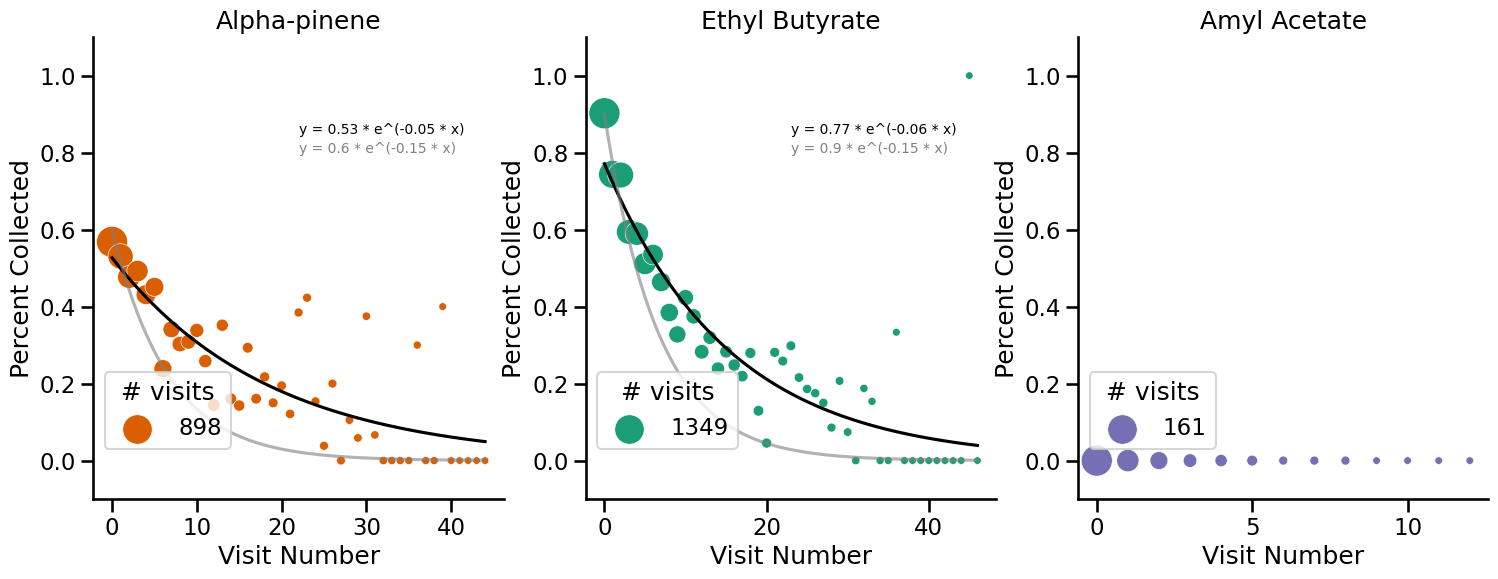

In [102]:
fig, ax = plt.subplots(1,3,figsize=(18, 6))
i = 0
for odor in dict.keys():

    odor_df = summary.loc[summary['odor_label'] == odor]
    # odor_df = odor_df.loc[~((odor_df.percent_collected == 1.0)&(odor_df.visit_number > 10))]
    odor_df = odor_df.loc[(odor_df.visit_number_count != 1.0)]

    sns.scatterplot(odor_df, x='visit_number', size="visit_number_count", sizes=(30, 500), y='percent_collected', color=dict[odor]['color'], ax=ax[i])
    
    # Plot exponential curve
    popt, pcov = curve_fit(exponential_func, odor_df['visit_number'], odor_df['percent_collected'], maxfev = 1500, bounds=([-np.inf, -np.inf], [np.inf, 1]))
    
    # Plot curve for this odor in theroy
    rate = dict[odor]['rate']
    offset = dict[odor]['offset']
    
    if popt[1] < 0:
        x_values = np.linspace(odor_df['visit_number'].min(), odor_df['visit_number'].max(), 100)
        ax[i].plot(x_values, exponential_func(x_values, *popt), color='black', label='Exponential Fit')
        
        # Exponential
        # ax[i].plot(x_values, exponential_func(x_values, offset, rate), color='grey', alpha=0.6, label='Exponential Fit')
        
        # Calculate y values using the power function y = ax^b
        y_values = offset * np.power(math.e, x_values* rate)
        ax[i].plot(x_values, y_values, color='grey', alpha=0.6, label='Exponential Fit')

        ax[i].text(max(odor_df.visit_number)/2, 0.85, f'y = {popt[0]:.2f} * e^({popt[1]:.2f} * x)', color='black', fontsize=10, )
        ax[i].text(max(odor_df.visit_number)/2, 0.80, f'y = {offset} * e^({rate} * x)', color='grey', fontsize=10, )

    ax[i].legend(bbox_to_anchor=(0.0,0.3), loc='upper left', labels=[max(odor_df.visit_number_count)], markerscale=1.3, title='# visits')
    ax[i].set_ylim(-0.1,1.1)
    ax[i].set_title(odor)
    ax[i].set_xlabel('Visit Number')
    ax[i].set_ylabel('Percent Collected')
    sns.despine()
    i += 1

TypeError: unbound method dict.keys() needs an argument

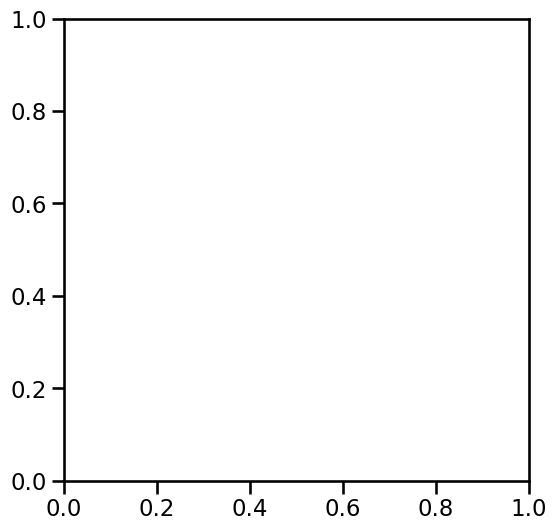

In [2]:
fig, ax = plt.subplots(1,1,figsize=(6, 6))

for odor in dict.keys():

    odor_df = summary.loc[summary['odor_label'] == odor]
    # odor_df = odor_df.loc[~((odor_df.percent_collected == 1.0)&(odor_df.visit_number > 10))]
    odor_df = odor_df.loc[(odor_df.visit_number_count != 1.0)]
    if dict[odor]['offset'] == 0.6:
        odor_df.visit_number+=3
    sns.scatterplot(odor_df, x='visit_number', size="visit_number_count", sizes=(30, 500), y='percent_collected', color=dict[odor]['color'], ax=ax)
    
    ax.set_ylim(-0.1,1.1)
    ax.set_xlabel('Visit Number')
    ax.set_ylabel('Percent Collected')
    sns.despine()

ax.legend(bbox_to_anchor=(0.7,1), ncol= 3, loc='upper left', title='# visits')
